In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import copy

In [2]:
def classify (img, correct_class=None, target_class=None, show_image=False):

    # copy image to new object
    tensor_img = copy.deepcopy(img)
    tensor_img = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                      std=[0.229, 0.224, 0.225])(tensor_img)
    tensor_img = tensor_img.unsqueeze_(0).to(device)

    inception_net.eval()
    outputs = inception_net(tensor_img)[0]
    outputs = F.softmax(outputs, dim=0)

    # Retrieve the sorted output with categories
    sorted_outputs, indices = torch.sort(outputs, descending=True) 
    indices = indices.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    topk = list(indices[:10])
    topprobs = outputs[topk]
    
    if show_image:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,8))
        barlist = ax2.bar(range(10), topprobs)

        if target_class in topk:
            barlist[topk.index(target_class)].set_color('r')
        if correct_class in topk:
            barlist[topk.index(correct_class)].set_color('g')

            fig.sca(ax1)
            ax1.imshow(transforms.ToPILImage()(img))
            plt.sca(ax2)
            plt.ylim([0, 1.1])

            plt.xticks(range(10), 
                       [imagenet_labels[i][:15] for i in topk], 
                       rotation = 'vertical')
            fig.subplots_adjust(bottom = 0.2)
            plt.show()
    
    return tensor_img

In [3]:
#Initialize random number generators
# np.random.seed(1234)
# torch.manual_seed(1234)
img_class = 281 # chainlink fence
target_img_class = 924 # guacamole
learning_rate_gd = 1e-1
momentum = 0.9
epsilon = 2.0/255.0
loss_threshold = 1e-4
steps = 100
source_img_filename = 'cat.jpg'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

imagenet_json = "imagenet.json"
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

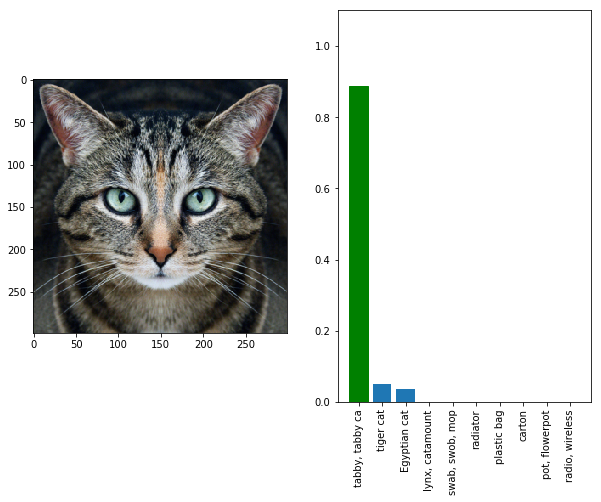

In [4]:
# Load pre-trained model
inception_net = models.inception_v3(pretrained=True).to(device)

source_img = Image.open(source_img_filename)
x_img = transforms.Compose([transforms.Resize(299), 
                            transforms.CenterCrop(299), 
                            transforms.ToTensor()])(source_img)

_ = classify(x_img, correct_class = img_class, show_image=True)

Starting adversarial training...
Progress : pass 10/100; loss = 5.371210098266602
Progress : pass 20/100; loss = 1.2832441329956055
Progress : pass 30/100; loss = 0.015192031860351562
Progress : pass 40/100; loss = 0.0033769607543945312
Progress : pass 50/100; loss = 0.0016584396362304688
Progress : pass 60/100; loss = 0.0009670257568359375
Progress : pass 70/100; loss = 0.0006694793701171875
Progress : pass 80/100; loss = 0.000530242919921875
Progress : pass 90/100; loss = 0.0004482269287109375
Progress : pass 100/100; loss = 0.0003948211669921875
Done training...!


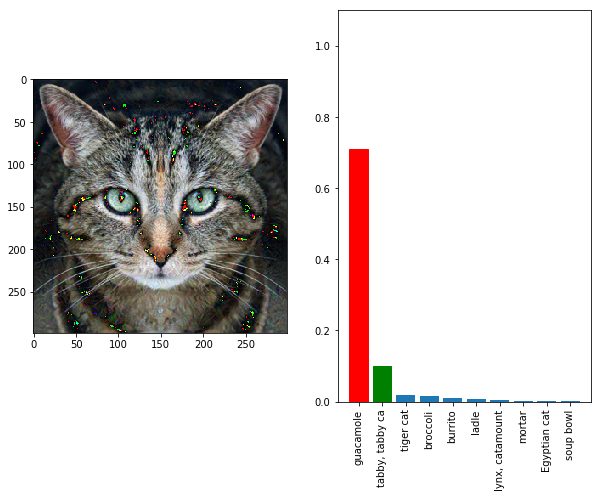

In [5]:
# Create new output image initialized with existing image
x_img = x_img.unsqueeze(0)
x_hat = copy.deepcopy(x_img).to(device)
x_hat.requires_grad = True

# GD step
y_hat_target = torch.LongTensor(1).to(device)
y_hat_target[0] = target_img_class

criterions = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = [x_hat], lr = learning_rate_gd, momentum = momentum)

print("Starting adversarial training...")
for i in range(steps):
    optimizer.zero_grad()
    y_hat = inception_net.forward(x_hat).to(device)
    loss = criterions(y_hat, y_hat_target)
    loss.backward()
    # Clip gradients
    x_hat.grad.data.clamp_(-epsilon, epsilon)
    optimizer.step()
    if (i+1) % 10 == 0:
        print("Progress : pass " + str(i+1) + "/" + str(steps) + "; loss = " + str(loss.item()))
    if loss.item() < loss_threshold:
        print("Loss below threshold of " + str(loss_threshold) + " reached at epoch " + str(i))
        break

print("Done training...!")

_ = classify(x_hat.squeeze().detach().cpu(), 
             correct_class=img_class, 
             target_class=target_img_class, 
             show_image=True)

torch.Size([1, 3, 299, 299])
torch.Size([1, 3, 299, 299])


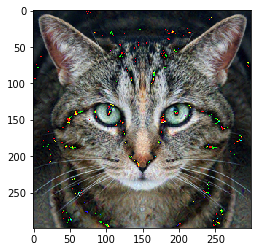

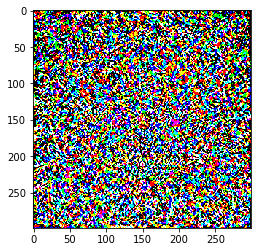

In [6]:
def show(img):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img)
    ax.imshow(img)
    
print(x_hat.shape)
show(x_hat[0].cpu())
pert1 = x_hat.cpu()- x_img
print(pert1.shape)
show(pert1[0])

In [7]:
x_img_t = x_hat.squeeze().detach().cpu().numpy()
print(x_img_t.shape)
x_img_t = x_img_t.transpose((1, 2, 0))
print(x_img_t.shape)

(3, 299, 299)
(299, 299, 3)


In [8]:
import cv2
import numpy as np
import sys

w, h = x_img_t.shape[0:2]
anglex = 0
angley = 45
anglez = 0  # 是旋转
fov = 42
r = 0

def rad(x):
    return x * np.pi / 180

def get_warpR():
    global anglex,angley,anglez,fov,w,h,r
    # 镜头与图像间的距离，21为半可视角，算z的距离是为了保证在此可视角度下恰好显示整幅图像
    z = np.sqrt(w ** 2 + h ** 2) / 2 / np.tan(rad(fov / 2))
    # 齐次变换矩阵
    rx = np.array([[1, 0, 0, 0],
                   [0, np.cos(rad(anglex)), -np.sin(rad(anglex)), 0],
                   [0, -np.sin(rad(anglex)), np.cos(rad(anglex)), 0, ],
                   [0, 0, 0, 1]], np.float32)

    ry = np.array([[np.cos(rad(angley)), 0, np.sin(rad(angley)), 0],
                   [0, 1, 0, 0],
                   [-np.sin(rad(angley)), 0, np.cos(rad(angley)), 0, ],
                   [0, 0, 0, 1]], np.float32)

    rz = np.array([[np.cos(rad(anglez)), np.sin(rad(anglez)), 0, 0],
                   [-np.sin(rad(anglez)), np.cos(rad(anglez)), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]], np.float32)

    r = rx.dot(ry).dot(rz)

    # 四对点的生成
    pcenter = np.array([h / 2, w / 2, 0, 0], np.float32)

    p1 = np.array([0, 0, 0, 0], np.float32) - pcenter
    p2 = np.array([w, 0, 0, 0], np.float32) - pcenter
    p3 = np.array([0, h, 0, 0], np.float32) - pcenter
    p4 = np.array([w, h, 0, 0], np.float32) - pcenter

    dst1 = r.dot(p1)
    dst2 = r.dot(p2)
    dst3 = r.dot(p3)
    dst4 = r.dot(p4)

    list_dst = [dst1, dst2, dst3, dst4]

    org = np.array([[0, 0],
                    [w, 0],
                    [0, h],
                    [w, h]], np.float32)

    dst = np.zeros((4, 2), np.float32)

    # 投影至成像平面
    for i in range(4):
        dst[i, 0] = list_dst[i][0] * z / (z - list_dst[i][2]) + pcenter[0]
        dst[i, 1] = list_dst[i][1] * z / (z - list_dst[i][2]) + pcenter[1]

    warpR = cv2.getPerspectiveTransform(org, dst)
    return warpR

warpR = get_warpR()
result = cv2.warpPerspective(x_img_t, warpR, (h, w))
print(result.shape)

(299, 299, 3)


In [9]:
x_tr = result.transpose((2,0,1))
print(x_tr.shape)
x_tr = torch.from_numpy(x_tr)
print(x_tr.shape)

(3, 299, 299)
torch.Size([3, 299, 299])


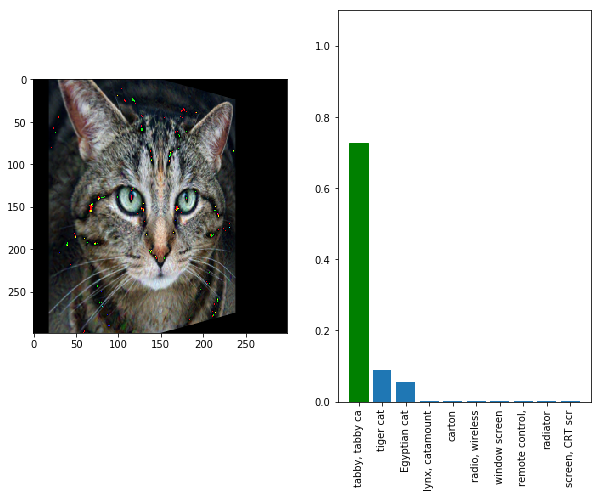

In [10]:
_ = classify(x_tr, 
             correct_class=img_class, 
             target_class=target_img_class, 
             show_image=True)

torch.Size([3, 299, 299])
torch.Size([3, 299, 299])


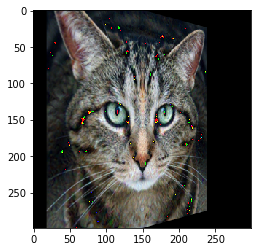

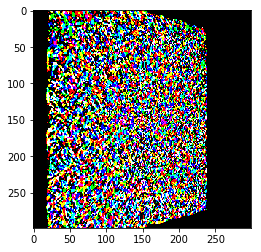

In [11]:
show(x_tr)
x_imgs = x_img.squeeze().detach().cpu().numpy()
x_imgs = np.transpose(x_imgs, (1, 2, 0))
x_img_tr = cv2.warpPerspective(x_imgs, warpR, (h, w))
x_img_tr = np.transpose(x_img_tr, (2, 0, 1))
x_img_tr = torch.from_numpy(x_img_tr)
print(x_img_tr.shape)
pert2 = x_tr - x_img_tr
print(pert2.shape)
show(pert2)

In [12]:
x_tr = x_tr.unsqueeze(0).to(device)
x_tr.requires_grad = True
print(x_tr.shape)

torch.Size([1, 3, 299, 299])


In [13]:
epsilon = 2.0/255.0
steps = 100
optimizer = optim.ASGD(params = [x_tr], lr = learning_rate_gd)

Starting adversarial training...
Progress : pass 10/100; loss = 0.7731571197509766
Progress : pass 20/100; loss = 0.03976249694824219
Progress : pass 30/100; loss = 0.02291107177734375
Progress : pass 40/100; loss = 0.01685333251953125
Progress : pass 50/100; loss = 0.013583183288574219
Progress : pass 60/100; loss = 0.011426925659179688
Progress : pass 70/100; loss = 0.0099334716796875
Progress : pass 80/100; loss = 0.008831024169921875
Progress : pass 90/100; loss = 0.00795745849609375
Progress : pass 100/100; loss = 0.0072498321533203125
Done training...!


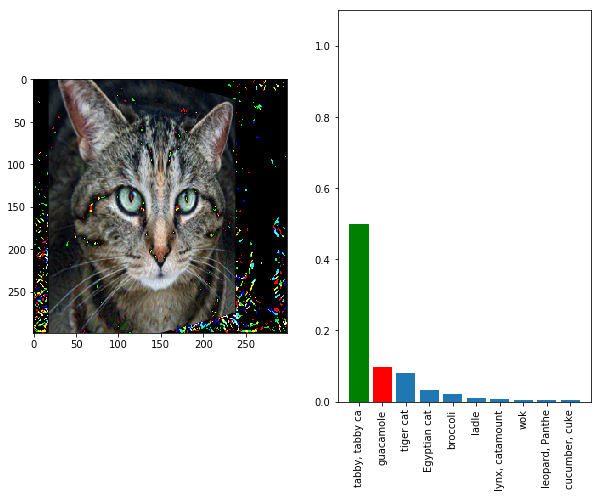

In [14]:
print("Starting adversarial training...")
for i in range(steps):
    optimizer.zero_grad()
    y_hat = inception_net.forward(x_tr).to(device)
    # [Jun's remark]
    # y_hat = inception_net.forward(geom_transform(x_tr)).to(device) -->
    # e.g.
    # masked_x_trn = mask * x_tr # mask is a binary image of (height, weight)
    # warpped_masked_x_trn = cv2.warpPerspective(masked_x_trn, warpR, (h, w))
    # y_hat = inception_net.forward(warpped_masked_x_trn).to(device) 
    loss = criterions(y_hat, y_hat_target)
    loss.backward()
    # Clip gradients
    x_tr.grad.data.clamp_(-epsilon, epsilon)
    # [Jun's remark]
    # x_tr.grad.data.clamp_(-epsilon, epsilon) -->
    # warpped_masked_x_trn.grad.data.clamp_(-epsilon, epsilon)
    # e.g.
    # masked_x_trn.grad = inverseWarpPerspective()
    # warpped_masked_x_trn = cv2.warpPerspective(masked_x_trn, warpR, (h, w))
    # y_
    optimizer.step()
    if (i+1) % 10 == 0:
        print("Progress : pass " + str(i+1) + "/" + str(steps) + "; loss = " + str(loss.item()))
    if loss.item() < loss_threshold:
        print("Loss below threshold of " + str(loss_threshold) + " reached at epoch " + str(i))
        break

print("Done training...!")

_ = classify(x_tr.squeeze().detach().cpu(), 
             correct_class=img_class, 
             target_class=target_img_class, 
             show_image=True)

torch.Size([1, 3, 299, 299])
torch.Size([3, 299, 299])


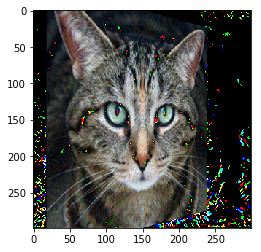

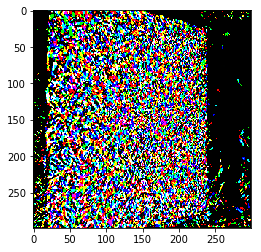

In [15]:
print(x_tr.shape)
show(x_tr[0].cpu())
pert3 = x_tr.squeeze().cpu() - x_img_tr
print(pert3.shape)
show(pert3)